In [38]:
import math
import time
from dataclasses import dataclass
from pathlib import Path
from typing import Sequence, Tuple, Union, Optional, Any, Dict, List, Iterator
import unittest
from abc import ABC, abstractmethod
from matplotlib import pyplot as plt

import numpy as np
import torch

from torch import sigmoid
from torch import nn
import pandas as pd
import argparse
from torch.utils.data import TensorDataset, DataLoader


device: torch.device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device = torch.device("cpu")

print(f"using device: {device}")

using device: cpu


In [39]:
def _set_seed(seed: int) -> None:
    torch.manual_seed(seed)
    np.random.seed(seed)

**Хелперы для чтения и подготовки csv.**

In [40]:
def load_dataset(
    notest: bool = False,
) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:
    base = Path.cwd()
    train_x = pd.read_csv(
        base / "train_x.csv",
    )
    train_y = pd.read_csv(
        base / "train_y.csv",
    )
    if notest:
        return train_x, train_y, None
    test_x = pd.read_csv(
        base / "test_x.csv",
    )
    return train_x, train_y, test_x


def normalize_dataset(
    batch_size: int, train_x: pd.DataFrame, train_y: pd.DataFrame, test_x: pd.DataFrame
) -> Tuple[DataLoader, DataLoader, Dict[str, Any]]:
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split

    scaler = StandardScaler()

    X_sc = scaler.fit_transform(train_x)
    X_test_sc = scaler.transform(test_x)

    X_tensor = torch.tensor(X_sc, dtype=torch.float32)
    y_tensor = torch.tensor(train_y.values, dtype=torch.float32).view(-1)

    X_train, X_val, y_train, y_val = train_test_split(
        X_tensor, y_tensor, test_size=0.2, random_state=341
    )

    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    return (
        train_loader,
        val_loader,
        {
            "scaler": scaler,
            "X_test_sc": X_test_sc,
            "X_test_shape": test_x.shape,
        },
    )

**First MLP**

In [41]:
class MLP(torch.nn.Module):
    """MLP: 2 hidden layers + dropout"""

    def __init__(
        self,
        n_feats: int,
        hidden1: int,
        hidden2: int,
        dropout: float,
    ) -> None:
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(n_feats, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden2, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze(-1)

**Common train function**

In [42]:
def train(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int,
    loss_fn: nn.modules.Module,
    optimizer: torch.optim.Optimizer,
    scheduler: Any,
):
    print(f"[*] starting training")
    start_time = time.time()
    train_losses: list[float] = []
    val_losses: list[float] = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, lbls in train_loader:
            inputs = inputs.to(device)
            lbls = lbls.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = loss_fn(outputs, lbls)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()

        loss_val = 0.0
        with torch.no_grad():
            for inputs, lbls in val_loader:
                inputs = inputs.to(device)
                lbls = lbls.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, lbls)
                loss_val += loss.item()

        val_losses.append(loss_val / len(val_loader))
        if scheduler is not None:

            scheduler.step(val_losses[-1])

        time_elapsed = time.time() - start_time
        print(
            f"[{epoch}/{epochs}, {time_elapsed:.2f}s] train_loss: {train_losses[-1]:.4f}, val_loss: {val_losses[-1]:.4f}"
        )
        if scheduler is not None:
            print(f"[{epoch}/{epochs}] lr: {scheduler.get_last_lr()[0]:.6f}")
        else:
            try:
                print(f"[{epoch}/{epochs}] lr: {scheduler.get_last_lr()[0]:.6f}")
            except:
                pass

    return train_losses, val_losses

In [43]:
train_x, train_y, test_x = load_dataset()

In [44]:
train_x.head(1)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,80,81,82,83,84,85,86,87,88,89
0,133081,37.47518,-14.34414,40.54872,-9.10171,16.77175,-17.77113,-16.50156,-4.09543,2.49723,...,104.03557,-115.62803,-13.7966,31.60436,28.95927,-25.93164,67.6467,-25.76691,-81.90373,-61.48682


In [45]:
test_x.head(1)  # pyright: ignore[reportOptionalMemberAccess]

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,id
0,44.6997,7.96998,-15.16859,-15.88686,1.58073,-6.23497,-11.59792,-11.71405,4.32023,-8.56689,...,16.70871,22.73881,12.92728,5.35942,33.01436,-54.54467,-2.53457,19.44396,8.74708,3416


In [46]:
train_y.head(1)

,Unnamed: 0,year
0,133081,2001


In [47]:
test_id = test_x["id"]  # pyright: ignore[reportOptionalSubscript]
test_x = test_x.drop(columns=["id"])  # pyright: ignore[reportOptionalMemberAccess]
train_x = train_x.drop(columns=["Unnamed: 0"])
train_y = train_y.drop(columns=["Unnamed: 0"])


y_mean = train_y.mean()
y_std = train_y.std()
print(f"y mean: {y_mean}, y std: {y_std}")
train_y = (train_y - y_mean) / y_std

y mean: year    1998.366714
dtype: float64, y std: year    11.048088
dtype: float64


**First pass: MSE + Adam + ReduceLR**

In [48]:
BATCH_SIZE = 16

train_loader, val_loader, normalized_test = normalize_dataset(
    BATCH_SIZE, train_x, train_y, test_x
)

In [49]:
HIDDEN1: int = 32
HIDDEN2: int = 16
DROPOUT: float = 0.1
OPTIM_LR: float = 3e-4

model = MLP(
    n_feats=train_x.shape[1],
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    dropout=DROPOUT,
).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=OPTIM_LR,
)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.4, patience=4, mode="min", min_lr=1e-7
)

In [50]:
EPOCHS = 30

train_losses, val_losses = train(
    model, train_loader, val_loader, EPOCHS, criterion, optimizer, lr_scheduler
)

[*] starting training
[0/30, 0.47s] train_loss: 0.9172, val_loss: 0.8072
[0/30] lr: 0.000300
[1/30, 0.81s] train_loss: 0.7946, val_loss: 0.7282
[1/30] lr: 0.000300
[2/30, 1.16s] train_loss: 0.7460, val_loss: 0.7033
[2/30] lr: 0.000300
[3/30, 1.52s] train_loss: 0.7200, val_loss: 0.6883
[3/30] lr: 0.000300
[4/30, 1.86s] train_loss: 0.7046, val_loss: 0.6801
[4/30] lr: 0.000300
[5/30, 2.20s] train_loss: 0.6959, val_loss: 0.6753
[5/30] lr: 0.000300
[6/30, 2.53s] train_loss: 0.6794, val_loss: 0.6702
[6/30] lr: 0.000300
[7/30, 2.86s] train_loss: 0.6690, val_loss: 0.6666
[7/30] lr: 0.000300
[8/30, 3.19s] train_loss: 0.6662, val_loss: 0.6673
[8/30] lr: 0.000300
[9/30, 3.52s] train_loss: 0.6632, val_loss: 0.6656
[9/30] lr: 0.000300
[10/30, 3.84s] train_loss: 0.6551, val_loss: 0.6715
[10/30] lr: 0.000300
[11/30, 4.16s] train_loss: 0.6453, val_loss: 0.6613
[11/30] lr: 0.000300
[12/30, 4.61s] train_loss: 0.6386, val_loss: 0.6609
[12/30] lr: 0.000300
[13/30, 4.95s] train_loss: 0.6314, val_loss: 0.66

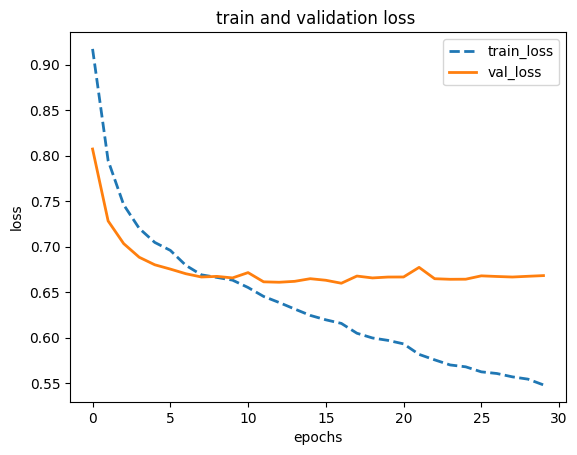

In [51]:
plt.plot(train_losses, label="train_loss", linewidth=2, linestyle="--")
plt.plot(val_losses, label="val_loss", linewidth=2)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("train and validation loss ")
plt.show()

**Common error-true graph builder**

In [ ]:
def error_true_plot(
    model: nn.Module, train_loader: DataLoader, y_mean: pd.Series, y_std: pd.Series
) -> pd.DataFrame:
    model.eval()
    y_true_list, y_pred_list = [], []
    with torch.no_grad():
        for xb, yb in train_loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy().ravel()
            y_pred_list.append(preds)
            y_true_list.append(yb.cpu().numpy().ravel())

    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)

    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    print(f"[train] mae: {mae:.4f}, rmse: {rmse:.4f}")

    df = pd.DataFrame(
        {
            "y_true": y_true.astype(int),
            "y_pred": np.round(y_pred).astype(int),
        }
    )
    df["err"] = df["y_true"] - df["y_pred"]
    print(df.head(10))

    true = df["y_true"].to_numpy().astype(float)
    err = df["err"].to_numpy().astype(float)

    _y_mean = np.array(y_mean).squeeze()
    _y_std = np.array(y_std).squeeze()

    y_true_orig = y_true * _y_std + _y_mean
    y_pred_orig = y_pred * _y_std + _y_mean

    residual = y_pred_orig - y_true_orig
    n = len(residual)
    mae = np.mean(np.abs(residual))
    rmse = np.sqrt(np.mean(residual**2))

    fig, ax = plt.subplots(figsize=(10, 6))
    # hb = ax.hexbin(y_true_orig, residual, gridsize=80, cmap="Blues", mincnt=1)
    # cb = fig.colorbar(hb, ax=ax)
    # cb.set_label("counts")
    ax.scatter(y_true_orig, residual, s=4, color="k", alpha=0.05, zorder=1)
    hb = ax.hexbin(y_true_orig, residual, gridsize=80, cmap="Blues",
                   mincnt=5, bins="log", zorder=2)
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label("counts")
    
    # binned mean / std
    n_bins = 40
    bins = np.linspace(y_true_orig.min(), y_true_orig.max(), n_bins + 1)
    idx = np.digitize(y_true_orig, bins) - 1
    centers = 0.5 * (bins[:-1] + bins[1:])
    means = np.array(
        [
            residual[idx == i].mean() if np.any(idx == i) else np.nan
            for i in range(n_bins)
        ]
    )
    stds = np.array(
        [
            residual[idx == i].std() if np.any(idx == i) else np.nan
            for i in range(n_bins)
        ]
    )
    valid = ~np.isnan(means)

    def smooth(x, w=3):
        if x.size < w:
            return x
        return np.convolve(x, np.ones(w) / w, mode="same")

    means_s = smooth(means[valid], w=3)
    stds_s = smooth(stds[valid], w=3)

    ax.plot(centers[valid], means_s, color="red", lw=2, label="mean")
    ax.fill_between(
        centers[valid],
        means_s - stds_s,
        means_s + stds_s,
        color="red",
        alpha=0.22,
        label="±1 std",
    )
    ax.axhline(0, color="gray", lw=1, linestyle="--")
    ax.set_xlabel("True Values")
    ax.set_ylabel("Error (pred - true)")
    ax.set_title(f"Error vs True (n={n}) — MAE={mae:.2f}, RMSE={rmse:.2f}")
    ax.grid(alpha=0.25)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

    return df

[-0.12370596  0.6909147   0.96245486 ... -1.3908936   0.6909147
 -0.03319256]
[train] mae: 0.5144, rmse: 0.7248
   y_true  y_pred  err
0       0       0    0
1       0       0    0
2       0       1   -1
3       0       1   -1
4       0       0    0
5       0       0    0
6       0       0    0
7       0       1   -1
8       0      -1    1
9       0      -1    1


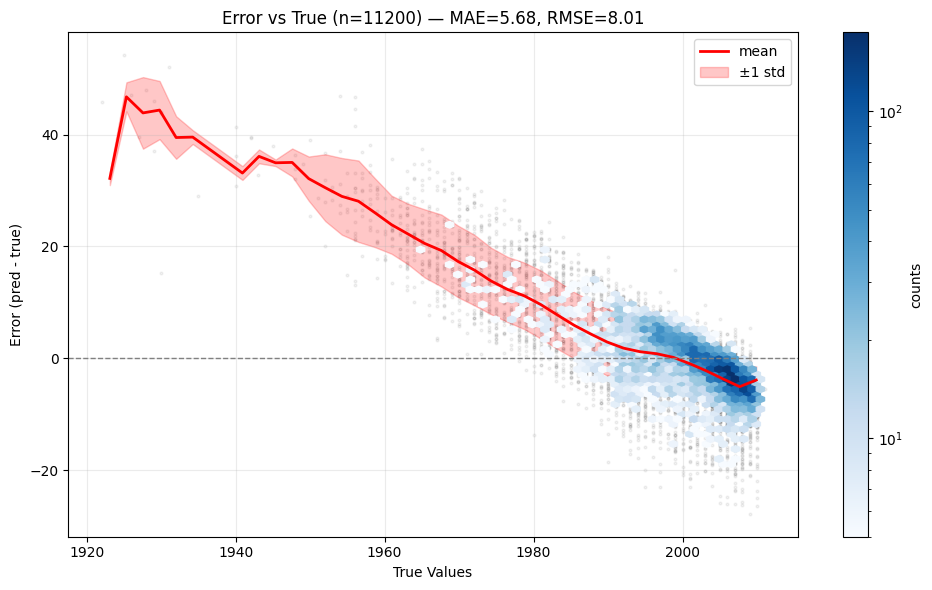

In [81]:
df = error_true_plot(model, train_loader, y_mean, y_std)

In [77]:
# how many years 1900-2000 in df['y_true']
years19002000 = ((df["y_true"] >= 1900) & (df["y_true"] <= 1989)).sum()
years2000to = (df["y_true"] > 2000).sum()

print(f"years 1900-2000: {years19002000}, years 2001-2023: {years2000to}")

years 1900-2000: 0, years 2001-2023: 0


**Моделька как будто тянет его наверх. Оно и понятно: у нас большая концентрация песен в 1990-... годах **

Далее я решил брать l1loss далее

In [55]:
train_x, train_y, test_x = load_dataset()
test_id = test_x["id"]  # pyright: ignore[reportOptionalSubscript]
test_x = test_x.drop(columns=["id"])  # pyright: ignore[reportOptionalMemberAccess]
train_x = train_x.drop(columns=["Unnamed: 0"])
train_y = train_y.drop(columns=["Unnamed: 0"])
y_mean = train_y.mean()
y_std = train_y.std()
print(f"y mean: {y_mean}, y std: {y_std}")
train_y = (train_y - y_mean) / y_std


model = MLP(
    n_feats=train_x.shape[1],
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    dropout=DROPOUT,
).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=OPTIM_LR)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.4, patience=4, mode="min", min_lr=1e-7
)

EPOCHS = 30

train_losses, val_losses = train(
    model, train_loader, val_loader, EPOCHS, criterion, optimizer, lr_scheduler
)

y mean: year    1998.366714
dtype: float64, y std: year    11.048088
dtype: float64
[*] starting training
[0/30, 0.37s] train_loss: 0.6756, val_loss: 0.6240
[0/30] lr: 0.000300
[1/30, 0.78s] train_loss: 0.6228, val_loss: 0.5856
[1/30] lr: 0.000300
[2/30, 1.19s] train_loss: 0.5928, val_loss: 0.5642
[2/30] lr: 0.000300
[3/30, 1.57s] train_loss: 0.5760, val_loss: 0.5562
[3/30] lr: 0.000300
[4/30, 1.98s] train_loss: 0.5674, val_loss: 0.5539
[4/30] lr: 0.000300
[5/30, 2.38s] train_loss: 0.5626, val_loss: 0.5510
[5/30] lr: 0.000300
[6/30, 3.01s] train_loss: 0.5574, val_loss: 0.5495
[6/30] lr: 0.000300
[7/30, 3.38s] train_loss: 0.5534, val_loss: 0.5464
[7/30] lr: 0.000300
[8/30, 3.74s] train_loss: 0.5489, val_loss: 0.5453
[8/30] lr: 0.000300
[9/30, 4.08s] train_loss: 0.5495, val_loss: 0.5461
[9/30] lr: 0.000300
[10/30, 4.42s] train_loss: 0.5449, val_loss: 0.5453
[10/30] lr: 0.000300
[11/30, 4.77s] train_loss: 0.5424, val_loss: 0.5468
[11/30] lr: 0.000300
[12/30, 5.13s] train_loss: 0.5409, val

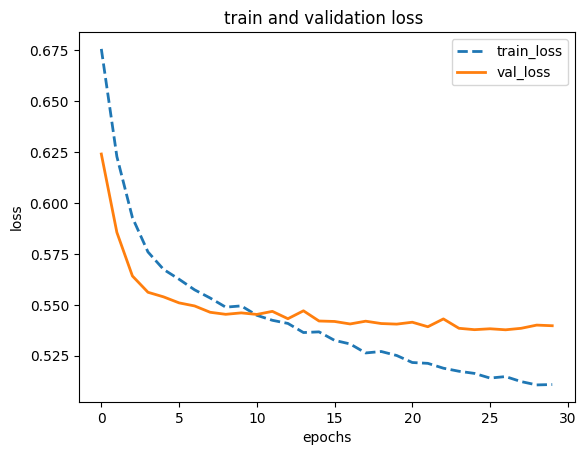

In [56]:
plt.plot(train_losses, label="train_loss", linewidth=2, linestyle="--")
plt.plot(val_losses, label="val_loss", linewidth=2)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("train and validation loss ")
plt.show()

[train] mae: 0.4849, rmse: 0.7764
   y_true  y_pred  err
0       0       0    0
1       0       1   -1
2       0       0    0
3       0       0    0
4       0       1   -1
5       0       0    0
6       0       1   -1
7       0       1   -1
8      -1      -1    0
9       0       1   -1


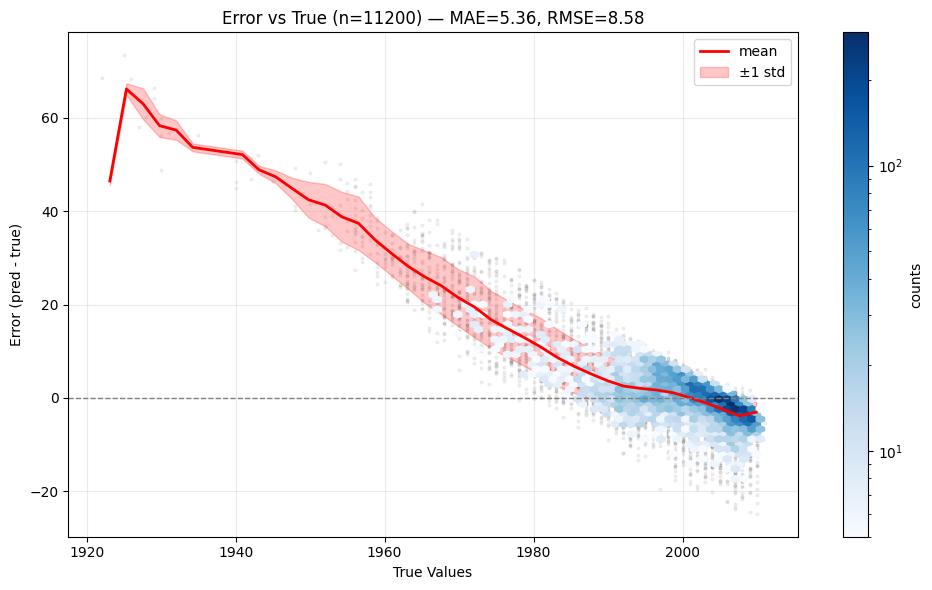

In [57]:
df = error_true_plot(model, train_loader, y_mean, y_std)

Так и не нашел лучший. Я выше здесь пробовал здесь еще разные scheduler(и убирал его), разные параметры, оптимизаторы. Взял в итоке adam+mseloss+lrreduce



In [58]:
train_x, train_y, test_x = load_dataset()
test_id = test_x["id"]  # pyright: ignore[reportOptionalSubscript]
test_x = test_x.drop(columns=["id"])  # pyright: ignore[reportOptionalMemberAccess]
train_x = train_x.drop(columns=["Unnamed: 0"])
train_y = train_y.drop(columns=["Unnamed: 0"])
y_mean = train_y.mean()
y_std = train_y.std()
print(f"y mean: {y_mean}, y std: {y_std}")
train_y = (train_y - y_mean) / y_std
BATCH_SIZE = 16
train_loader, val_loader, normalized_test = normalize_dataset(
    BATCH_SIZE, train_x, train_y, test_x
)

HIDDEN1: int = 32
HIDDEN2: int = 16
DROPOUT: float = 0.1
OPTIM_LR: float = 3e-4

model = MLP(
    n_feats=train_x.shape[1],
    hidden1=HIDDEN1,
    hidden2=HIDDEN2,
    dropout=DROPOUT,
).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=OPTIM_LR,
)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.4, patience=4, mode="min", min_lr=1e-7
)

EPOCHS = 30

train_losses, val_losses = train(
    model, train_loader, val_loader, EPOCHS, criterion, optimizer, lr_scheduler
)

y mean: year    1998.366714
dtype: float64, y std: year    11.048088
dtype: float64
[*] starting training
[0/30, 0.38s] train_loss: 0.9245, val_loss: 0.8131
[0/30] lr: 0.000300
[1/30, 0.74s] train_loss: 0.7929, val_loss: 0.7305
[1/30] lr: 0.000300
[2/30, 1.08s] train_loss: 0.7411, val_loss: 0.7037
[2/30] lr: 0.000300
[3/30, 1.42s] train_loss: 0.7166, val_loss: 0.6859
[3/30] lr: 0.000300
[4/30, 1.79s] train_loss: 0.7016, val_loss: 0.6861
[4/30] lr: 0.000300
[5/30, 2.15s] train_loss: 0.6867, val_loss: 0.6836
[5/30] lr: 0.000300
[6/30, 2.49s] train_loss: 0.6773, val_loss: 0.6755
[6/30] lr: 0.000300
[7/30, 2.82s] train_loss: 0.6681, val_loss: 0.6763
[7/30] lr: 0.000300
[8/30, 3.16s] train_loss: 0.6661, val_loss: 0.6781
[8/30] lr: 0.000300
[9/30, 3.50s] train_loss: 0.6534, val_loss: 0.6758
[9/30] lr: 0.000300
[10/30, 3.83s] train_loss: 0.6545, val_loss: 0.6751
[10/30] lr: 0.000300
[11/30, 4.16s] train_loss: 0.6450, val_loss: 0.6782
[11/30] lr: 0.000300
[12/30, 4.49s] train_loss: 0.6407, val

In [59]:
with torch.no_grad():
    inputes = torch.tensor(normalized_test["X_test_sc"], dtype=torch.float32).to(device)
    outputs = (
        model(inputes).detach().numpy() * y_std.to_numpy() + y_mean.to_numpy()
    ).round()

In [60]:
outputs

array([2000., 2005., 1998., ..., 1992., 1991., 1991.])

In [61]:
Y = pd.concat((test_id, pd.Series(outputs.ravel())), axis=1)
print(Y)

Y.to_csv("submission1.csv", index=False)

         id       0
0      3416  2000.0
1     18991  2005.0
2     11105  1998.0
3     18902  2002.0
4     18958  2003.0
...     ...     ...
5995  15293  2002.0
5996   7469  1987.0
5997   6586  1992.0
5998  17875  1991.0
5999  17290  1991.0

[6000 rows x 2 columns]


Давайте здесь упростим нашу модель -> один слой

In [62]:
class Net(torch.nn.Module):
    def __init__(
        self,
        n_feats: int,
        hidden1: int,
    ) -> None:
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(n_feats, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze(-1)

In [63]:
train_x, train_y, test_x = load_dataset()
test_id = test_x["id"]  # pyright: ignore[reportOptionalSubscript]
test_x = test_x.drop(columns=["id"])  # pyright: ignore[reportOptionalMemberAccess]
train_x = train_x.drop(columns=["Unnamed: 0"])
train_y = train_y.drop(columns=["Unnamed: 0"])
y_mean = train_y.mean()
y_std = train_y.std()
print(f"y mean: {y_mean}, y std: {y_std}")
train_y = (train_y - y_mean) / y_std
BATCH_SIZE = 16
train_loader, val_loader, normalized_test = normalize_dataset(
    BATCH_SIZE, train_x, train_y, test_x
)

OPTIM_LR = 3e-4
HIDDEN1 = 16
model1 = Net(train_x.shape[1], hidden1=HIDDEN1).to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(
    model1.parameters(),
    lr=OPTIM_LR,
)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.4, patience=4, mode="min", min_lr=1e-7
)

EPOCHS = 30

train_losses, val_losses = train(
    model1, train_loader, val_loader, EPOCHS, criterion, optimizer, lr_scheduler
)

y mean: year    1998.366714
dtype: float64, y std: year    11.048088
dtype: float64
[*] starting training
[0/30, 0.25s] train_loss: 0.3366, val_loss: 0.3025
[0/30] lr: 0.000300
[1/30, 0.47s] train_loss: 0.2994, val_loss: 0.2809
[1/30] lr: 0.000300
[2/30, 0.69s] train_loss: 0.2827, val_loss: 0.2724
[2/30] lr: 0.000300
[3/30, 0.92s] train_loss: 0.2753, val_loss: 0.2693
[3/30] lr: 0.000300
[4/30, 1.16s] train_loss: 0.2714, val_loss: 0.2663
[4/30] lr: 0.000300
[5/30, 1.39s] train_loss: 0.2685, val_loss: 0.2659
[5/30] lr: 0.000300
[6/30, 1.61s] train_loss: 0.2665, val_loss: 0.2651
[6/30] lr: 0.000300
[7/30, 1.83s] train_loss: 0.2647, val_loss: 0.2649
[7/30] lr: 0.000300
[8/30, 2.05s] train_loss: 0.2633, val_loss: 0.2649
[8/30] lr: 0.000300
[9/30, 2.27s] train_loss: 0.2623, val_loss: 0.2656
[9/30] lr: 0.000300
[10/30, 2.48s] train_loss: 0.2610, val_loss: 0.2658
[10/30] lr: 0.000300
[11/30, 2.70s] train_loss: 0.2603, val_loss: 0.2657
[11/30] lr: 0.000300
[12/30, 2.95s] train_loss: 0.2593, val

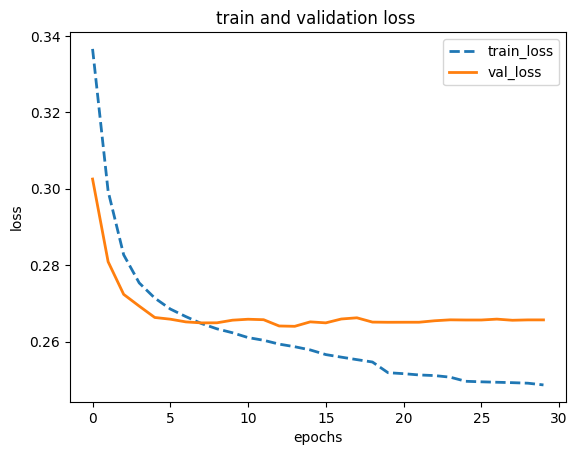

In [64]:
plt.plot(train_losses, label="train_loss", linewidth=2, linestyle="--")
plt.plot(val_losses, label="val_loss", linewidth=2)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("train and validation loss ")
plt.show()

[train] mae: 0.5370, rmse: 0.8084
   y_true  y_pred  err
0       0       0    0
1      -1       0   -1
2       0       0    0
3       0       1   -1
4       0       0    0
5      -1       0   -1
6       0       0    0
7      -1      -1    0
8      -1      -1    0
9       0       0    0


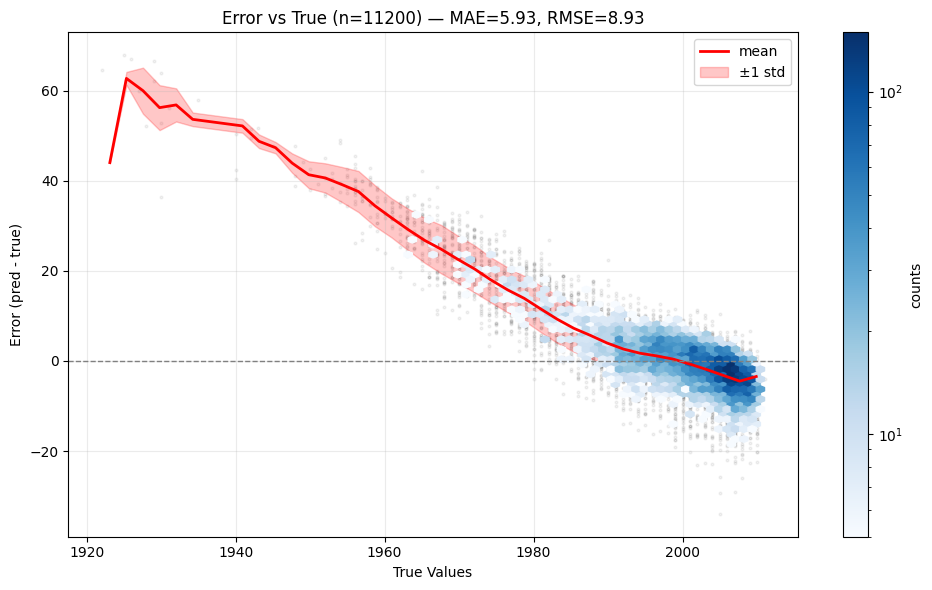

In [65]:
df = error_true_plot(model1, train_loader, y_mean, y_std)

Также подбор Scheduler не дал лучших результатов (если его убрать, то тоже). В итоге оставил hidden=64, l1, adam, ReduceLR.

Но при этом мы, в любом случае, получили лучший результат


In [66]:
with torch.no_grad():
    inputes = torch.tensor(normalized_test["X_test_sc"], dtype=torch.float32).to(device)
    outputs = (
        model1(inputes).detach().numpy() * y_std.to_numpy() + y_mean.to_numpy()
    ).round()

Y = pd.concat((test_id, pd.Series(outputs.ravel())), axis=1)
print(Y)

Y.to_csv("submission2.csv", index=False)

         id       0
0      3416  1999.0
1     18991  2004.0
2     11105  1997.0
3     18902  2004.0
4     18958  2001.0
...     ...     ...
5995  15293  2004.0
5996   7469  1995.0
5997   6586  1990.0
5998  17875  1995.0
5999  17290  1996.0

[6000 rows x 2 columns]


**Попробуем взять кастомный Adam**

In [ ]:
@dataclass
class Opt(ABC):
    def name(self) -> str:
        return self.__class__.__name__

    @abstractmethod
    def step(self, *args, **kwargs) -> Any:
        pass


@dataclass
class AdamOpt(Opt):
    lr: float = 3e-4
    beta1: float = 0.9
    beta2: float = 0.999
    eps: float = 1e-8

    parameters: Optional[List[nn.Parameter]] = None
    
    def __post_init__(self) -> None:
        assert self.parameters is not None
        self.parameters = list(self.parameters)
        for p in self.parameters:
            p.retain_grad()
        
        self.m: List[torch.Tensor] = []
        self.v: List[torch.Tensor] = []

    def step(
        self,
    ) -> None:
        assert self.parameters is not None
        if len(self.m) == 0:
            self.m = [torch.zeros_like(p) for p in self.parameters]
            self.v = [torch.zeros_like(p) for p in self.parameters]
        with torch.no_grad():
            for i, p in enumerate(self.parameters):
                assert p.grad is not None
                g = p.grad.data
                
                m = self.beta1 * self.m[i] + (1.0 - self.beta1) * g
                v = self.beta2 * self.v[i] + (1.0 - self.beta2) * (g * g)
                
                # -= it's in-place sub operation2
                p -= self.lr * m / (torch.sqrt(v) + self.eps)
                self.m[i] = m
                self.v[i] = v

        return None
    
    def get_last_lr(self) -> List[float]:
        return [self.lr]
    
    def zero_grad(self):
        assert self.parameters is not None
        for p in self.parameters:
            if p.grad is not None:
                p.grad.detach_()
                p.grad.data.zero_()

    


In [68]:
train_x, train_y, test_x = load_dataset()
test_id = test_x["id"]  # pyright: ignore[reportOptionalSubscript]
test_x = test_x.drop(columns=["id"])  # pyright: ignore[reportOptionalMemberAccess]
train_x = train_x.drop(columns=["Unnamed: 0"])
train_y = train_y.drop(columns=["Unnamed: 0"])
y_mean = train_y.mean()
y_std = train_y.std()
print(f"y mean: {y_mean}, y std: {y_std}")
train_y = (train_y - y_mean) / y_std
BATCH_SIZE = 256
train_loader, val_loader, normalized_test = normalize_dataset(
    BATCH_SIZE, train_x, train_y, test_x
)

OPTIM_LR = 3e-3
HIDDEN1 = 16
model1 = Net(train_x.shape[1], hidden1=HIDDEN1).to(device)
criterion = nn.SmoothL1Loss()
optimizer = AdamOpt(lr=OPTIM_LR, parameters=model1.parameters()) # pyright: ignore[reportArgumentType]

EPOCHS = 20

train_losses, val_losses = train(
    model1, train_loader, val_loader, EPOCHS, criterion, optimizer, None # pyright: ignore[reportArgumentType]
)

y mean: year    1998.366714
dtype: float64, y std: year    11.048088
dtype: float64
[*] starting training
[0/20, 0.07s] train_loss: 0.3085, val_loss: 0.2769
[1/20, 0.13s] train_loss: 0.2800, val_loss: 0.2681
[2/20, 0.27s] train_loss: 0.2717, val_loss: 0.2651
[3/20, 0.39s] train_loss: 0.2675, val_loss: 0.2668
[4/20, 0.44s] train_loss: 0.2635, val_loss: 0.2686
[5/20, 0.50s] train_loss: 0.2616, val_loss: 0.2691
[6/20, 0.56s] train_loss: 0.2591, val_loss: 0.2676
[7/20, 0.61s] train_loss: 0.2576, val_loss: 0.2692
[8/20, 0.67s] train_loss: 0.2554, val_loss: 0.2678
[9/20, 0.73s] train_loss: 0.2544, val_loss: 0.2662
[10/20, 1.22s] train_loss: 0.2511, val_loss: 0.2679
[11/20, 1.28s] train_loss: 0.2509, val_loss: 0.2718
[12/20, 1.33s] train_loss: 0.2478, val_loss: 0.2695
[13/20, 1.39s] train_loss: 0.2477, val_loss: 0.2711
[14/20, 1.44s] train_loss: 0.2460, val_loss: 0.2750
[15/20, 1.50s] train_loss: 0.2458, val_loss: 0.2733
[16/20, 1.56s] train_loss: 0.2453, val_loss: 0.2757
[17/20, 1.61s] train

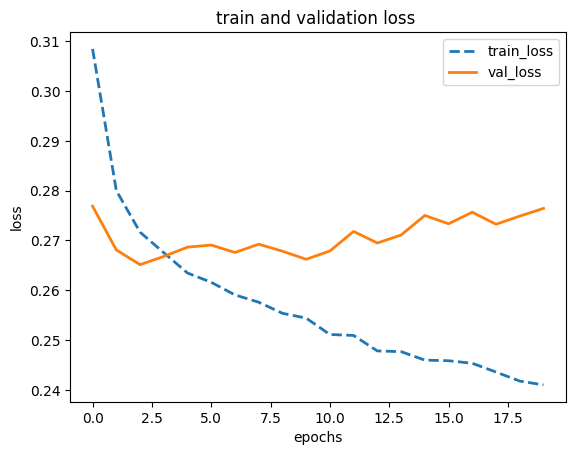

In [69]:
plt.plot(train_losses, label="train_loss", linewidth=2, linestyle="--")
plt.plot(val_losses, label="val_loss", linewidth=2)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("train and validation loss ")
plt.show()

[train] mae: 0.5255, rmse: 0.7838
   y_true  y_pred  err
0      -2      -1   -1
1       0       0    0
2       0       0    0
3       0       0    0
4       0       0    0
5       0       1   -1
6       0       0    0
7       0       1   -1
8       0       0    0
9       0       0    0


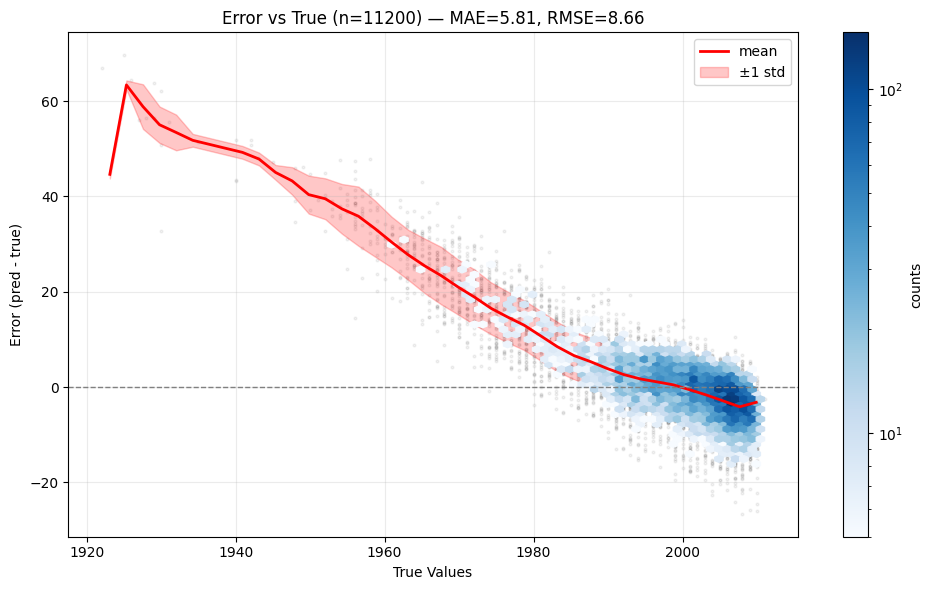

In [70]:
df = error_true_plot(model1, train_loader, y_mean, y_std)

Работает так же как и прошлый вариант с торч adam

Давайте уменьшим hidden1 до 32-16

In [71]:
train_x, train_y, test_x = load_dataset()
test_id = test_x["id"]  # pyright: ignore[reportOptionalSubscript]
test_x = test_x.drop(columns=["id"])  # pyright: ignore[reportOptionalMemberAccess]
train_x = train_x.drop(columns=["Unnamed: 0"])
train_y = train_y.drop(columns=["Unnamed: 0"])
y_mean = train_y.mean()
y_std = train_y.std()
print(f"y mean: {y_mean}, y std: {y_std}")
train_y = (train_y - y_mean) / y_std
BATCH_SIZE = 256
train_loader, val_loader, normalized_test = normalize_dataset(
    BATCH_SIZE, train_x, train_y, test_x
)

OPTIM_LR = 3e-3
OPTIM_WEIGHT_DECAY = 1e-4
HIDDEN1 = 16
model1 = Net(train_x.shape[1], hidden1=HIDDEN1).to(device)
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(
    model1.parameters(),
    lr=OPTIM_LR,
    weight_decay=OPTIM_WEIGHT_DECAY,

)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.4, patience=4, mode="min", min_lr=1e-7
)

EPOCHS = 20

train_losses, val_losses = train(
    model1, train_loader, val_loader, EPOCHS, criterion, optimizer, lr_scheduler
)

y mean: year    1998.366714
dtype: float64, y std: year    11.048088
dtype: float64
[*] starting training
[0/20, 0.06s] train_loss: 0.3279, val_loss: 0.2924
[0/20] lr: 0.003000
[1/20, 0.12s] train_loss: 0.2891, val_loss: 0.2733
[1/20] lr: 0.003000
[2/20, 0.18s] train_loss: 0.2760, val_loss: 0.2675
[2/20] lr: 0.003000
[3/20, 0.24s] train_loss: 0.2699, val_loss: 0.2696
[3/20] lr: 0.003000
[4/20, 0.30s] train_loss: 0.2661, val_loss: 0.2679
[4/20] lr: 0.003000
[5/20, 0.35s] train_loss: 0.2638, val_loss: 0.2662
[5/20] lr: 0.003000
[6/20, 0.41s] train_loss: 0.2614, val_loss: 0.2664
[6/20] lr: 0.003000
[7/20, 0.47s] train_loss: 0.2604, val_loss: 0.2681
[7/20] lr: 0.003000
[8/20, 0.52s] train_loss: 0.2595, val_loss: 0.2658
[8/20] lr: 0.003000
[9/20, 0.58s] train_loss: 0.2574, val_loss: 0.2675
[9/20] lr: 0.003000
[10/20, 0.64s] train_loss: 0.2550, val_loss: 0.2697
[10/20] lr: 0.003000
[11/20, 0.75s] train_loss: 0.2539, val_loss: 0.2695
[11/20] lr: 0.003000
[12/20, 0.81s] train_loss: 0.2532, val

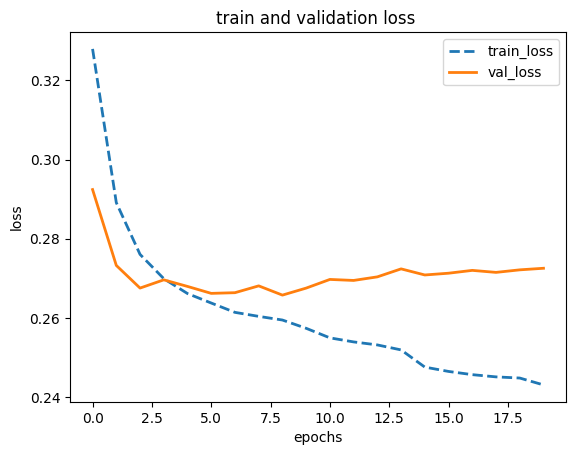

In [72]:
plt.plot(train_losses, label="train_loss", linewidth=2, linestyle="--")
plt.plot(val_losses, label="val_loss", linewidth=2)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("train and validation loss ")
plt.show()

[train] mae: 0.5293, rmse: 0.7943
   y_true  y_pred  err
0       0       0    0
1       0       0    0
2      -1       0   -1
3       0       0    0
4       0       0    0
5       0       1   -1
6       0       0    0
7       0       0    0
8       0       0    0
9       0       1   -1


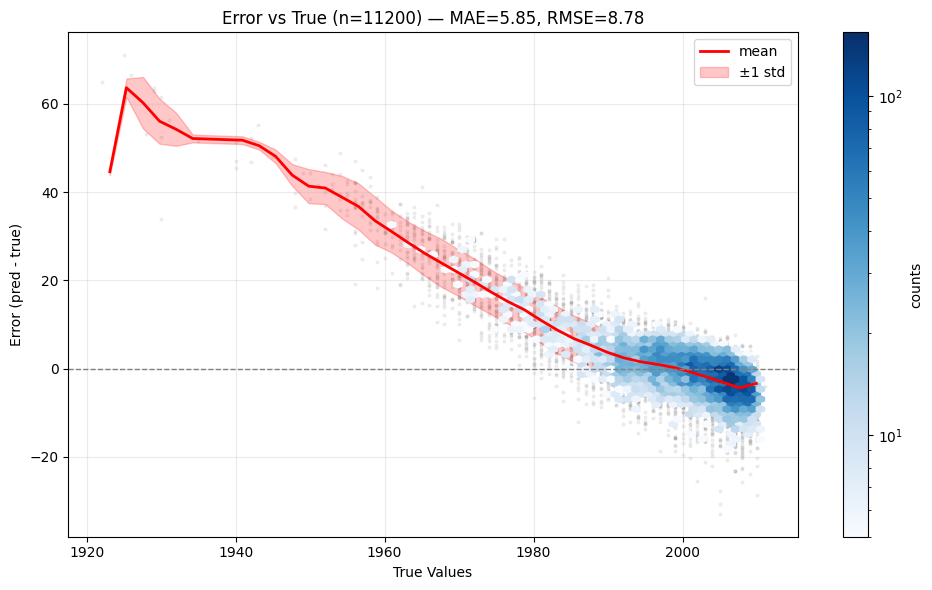

In [73]:
df = error_true_plot(model1, train_loader, y_mean, y_std)

In [74]:
with torch.no_grad():
    inputes = torch.tensor(normalized_test["X_test_sc"], dtype=torch.float32).to(device)
    outputs = (
        model1(inputes).detach().numpy() * y_std.to_numpy() + y_mean.to_numpy()
    ).round()

Y = pd.concat((test_id, pd.Series(outputs.ravel())), axis=1)
print(Y)

Y.to_csv("submission3.csv", index=False)

         id       0
0      3416  1999.0
1     18991  2005.0
2     11105  1996.0
3     18902  2004.0
4     18958  2002.0
...     ...     ...
5995  15293  2001.0
5996   7469  1995.0
5997   6586  1990.0
5998  17875  1994.0
5999  17290  1999.0

[6000 rows x 2 columns]


**В этоге, вариант 2(simple net + l1loss + adam) дал лучший результат**